In [11]:
import numpy as np
from scipy.stats import norm, expon
from scipy.special import logsumexp
import math
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
SEED = 2510

# Intro to Bayesian Inference II - MCMC - Supplementary theory

This notebook is supplementary material for the [Intro to Bayesian Inference II - MCMC](https://github.com/rchan26/rchan26.github.io/blob/main/pdfs/talks/bayesian_inference_talk_part_ii/part_ii.ipynb) talk. 

* In Section 1, we look at a simple inversion sampling example to get some intuition of the Monte Carlo sample and how we can obtain an approximation to the distribution as well as summary statistics. We see how our approximations change with sample size $N$.
* In Section 2, we look at Markov chains on discrete state spaces in more detail and hope to give more intuition on stationary distributions. 
* In Section 3, we consider a bimodal distribution example to explore the potential pitfalls of a naive Metropolis-Hastings sampler.

## 1: Monte Carlo example: Inversion sampling

One of the simplest Monte Carlo methods is called *inversion sampling* which is method for sampling from a distribution with probability density $\pi$ by inverting a random uniform random variable $u\sim\mathcal{U}[0,1]$.

The approach is as follows: suppose we have a distribution which we want to sample from with density $\pi$ and *cumulative distribution function (CDF)*,

$$
F_{\pi}(x) = P(X \leq x) \in [0,1].
$$

This represents the probability that our random variable takes a value *less than* $x$. The idea is that since this is between $0$ and $1$, we can generate a random number, $u$, between $0$ and $1$ and *invert* the CDF to get a sample, $X$, from the distribution:

$$
F_{\pi}^{-1}(u) = X.
$$

**NB:** James Geddes used this to sample from the distribution of letters in NYC in 'Probability I', but this was from a discrete distribution, so the we actually looked at the *generalised cumulative distribution function*:

$$
F_{\pi}^{-1}(u) = \inf_{x} \{F_{\pi}(x) \geq u\},
$$

which has several discontinuities, but is still valid.

### Exponential distribution

Suppose we wanted to simulate from an Exponential distribution with rate $\lambda$, denoted $\text{Exp}(\lambda)$, then this distribution has probability density

$$
f(x|\lambda) = \frac{1}{\lambda}\exp\left(-\frac{x}{\lambda}\right) \qquad x \geq 0, \lambda > 0,
$$

which has cumulative distribution function (CDF)

$$
F(x)=1-\exp\left(-\frac{x}{\lambda}\right).
$$

We can *invert* the CDF to get:

$$
F^{-1}(u)=-\lambda\log(1-u).
$$

So our algorithm to sample a single draw $X\sim\text{Exp}(\lambda)$ is as follows:
1. Sample $u\sim\mathcal{U}[0,1]$
2. Set $X=F^{-1}(u)$

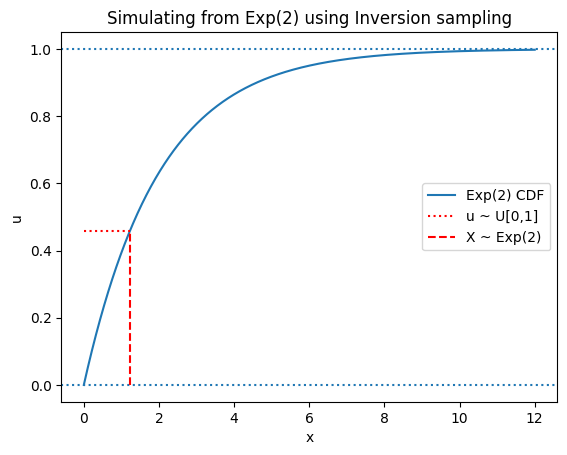

In [8]:
np.random.seed(SEED)
lambda_exp=2
exp_cdf = lambda x: 1-np.exp(-x/lambda_exp)
exp_inv_cdf = lambda u: -lambda_exp*np.log(1-u)
x = np.linspace(0, 12, 1000)
# simulate uniform random variable
U=np.random.uniform(size=1)
# invert the CDF 
X=exp_inv_cdf(U)

# plot
plt.plot(x, exp_cdf(x), label = 'Exp(2) CDF')
plt.axhline(y=0, linestyle=':')
plt.axhline(y=1, linestyle=':')
plt.hlines(y=U, xmin=0, xmax=X, linestyles=':', color='red', label = "u ~ U[0,1]")
plt.vlines(x=X, ymin=0, ymax=U, linestyles='--', color='red', label = "X ~ Exp(2)")
plt.ylabel('u')
plt.xlabel('x')
plt.legend()
plt.title(f"Simulating from Exp({lambda_exp}) using Inversion sampling")
plt.show()

We repeat this process $N$ times to get $N$ samples. We can then use these samples to approximate the $\text{Exp}(\lambda)$ distribution *and* any quantities with respect to it. By varying the number of samples $N$ which we get, we can see that our approximation to the distribution (just using a histogram approximation here) gets closer and closer to true probability density.

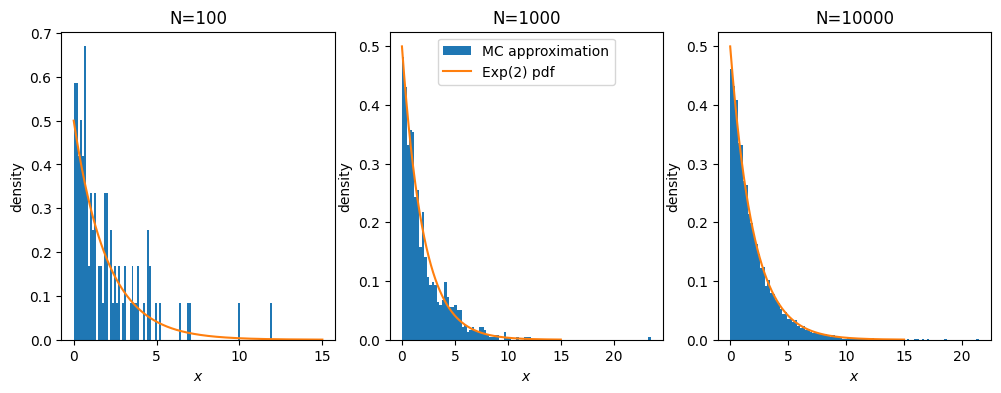

In [9]:
np.random.seed(SEED)
fig, ax = plt.subplots(1, 3, figsize=(12,4))

N=[100, 1000, 10000]
x = np.linspace(0, 15, 1000)
for i in range(3):
    U=np.random.uniform(size=N[i])
    X=-lambda_exp*np.log(1-U)
    ax[i].hist(X, bins = 100, density=True, label = 'MC approximation')
    ax[i].plot(x, expon.pdf(x, scale=lambda_exp),
               label = f"Exp({lambda_exp}) pdf")
    ax[i].set_title(f"N={N[i]}")
    ax[i].set_xlabel(r"$x$")
    ax[i].set_ylabel("density")
handles, labels = ax[i].get_legend_handles_labels()
ax[1].legend(handles, labels, loc='upper center')
plt.show()

We we say "approximate quantities with respect to the distribution", we typically mean approximating summary statistics, like the mean and variance, of the distribution, or maybe using it to make predictions (in a Bayesian context). Again, we can see that as we increase the number of samples, our approximations of the mean and variance (based on our Monte Carlo samples) get progressively closer to the true values.

In [10]:
N=[100, 1000, 10000]
x = np.linspace(0, 15, 1000)
print('True mean:', lambda_exp)
print('True variance', lambda_exp**2)
for i in range(3):
    U=np.random.uniform(size=N[i])
    X=-lambda_exp*np.log(1-U)
    print(f'---------- N={N[i]} ----------')
    print('Estimated mean:', np.mean(X))
    print('Estimated variance:', np.var(X))

True mean: 2
True variance 4
---------- N=100 ----------
Estimated mean: 2.174793026401915
Estimated variance: 2.668173373285281
---------- N=1000 ----------
Estimated mean: 2.0484367646815302
Estimated variance: 4.127005830202741
---------- N=10000 ----------
Estimated mean: 1.9932282854464771
Estimated variance: 4.0030726290770176


For most practical problems, however, we won't be able to find the cumulative distirbution function easily, and so this typically is not used for Bayesian inference.

## 2: Markov chains on discrete state spaces

The following introduction to Markov chains and MCMC draws substantially from the excellent ["An Introduction to MCMC for Machine Learning" by Andrieu, De Freitas, Doucet and Jordan (2003)](https://www.cs.ubc.ca/~arnaud/andrieu_defreitas_doucet_jordan_intromontecarlomachinelearning.pdf).

It's intuitive to first introduce Markov chains on finite state spaces, where the process $X_{t}$ can only take $S$ discrete values, so $X_{t} \in \mathcal{X}=\{x_{1},\dots,x_{S}\}$ for all $t$. In this case, we can work with the actual probability of the process having a particular value. Recall from James Geddes' Probability talks that working with *continuous random variables* need to handled with a bit more care and we actually work with probability *densities* instead.

A *discrete-time Markov chain* is sequence of random variables $X_{1}, X_{2}, \dots$, with the *Markov property* (or *memory-less property*).

$$
p(X_{n}=x_{n} | X_{n-1}=x_{n-1}, \dots, X_{0}=x_{0}) = p(X_{n}=x_{n} | X_{n-1}=x_{n-1}),
$$

where $p$ is the *transition density* of the Markov chain.

#### Homogenous Markov chains
The Markov chain is *homogeneous* if the transition probabilities $p(X_{n}=x_{n} | X_{n-1}=x_{n-1})$ are time-invariant - so the evolution of the chain in the space $\mathcal{X}$ depends *solely* on the current state of the chain and the transitions are fixed.

In this case, we can summarise the transition probabilities in a *transition matrix* and also visualise the chain with a *transition graph*.

For example, consider a Markov chain with three states $s=3$ and a transition graph illustrated below which shows the transition probabilities between the states:
![](example_1.jpg)

The transition probabilities of this chain can then be summarised into the following transition matrix:

$$
T = 
\begin{pmatrix}
    P(x_{1}|x_{1}) & P(x_{2}|x_{1}) & P(x_{3}|x_{1}) \\
    P(x_{1}|x_{2}) & P(x_{2}|x_{2}) & P(x_{3}|x_{2}) \\
    P(x_{1}|x_{3}) & P(x_{2}|x_{3}) & P(x_{3}|x_{3})
\end{pmatrix}
= 
\begin{pmatrix}
    0 & 1 & 0 \\
    0 & 0.1 & 0.9 \\
    0.6 & 0.4 & 0
\end{pmatrix}
$$

#### Inhomogeneous Markov chains
In a *inhomogeneous* Markov chain, the transition probabilities do depend explicitly on the index, but note that future probabilities of the chain do still only depend on the current state.

### Examples
Some examples of Markov chains are:
* **Any series of independent events**
    * e.g. series of coin flips, or dice rolls
    * The probability distribution of the next step doesn't actually change, so this is a trivial example
    * This is an example of a *homogeneous Markov chain*
    
For a (fair) coin flip, $\mathcal{X}=\{\text{Heads}, \text{Tails}\}$ and the transition matrix is:

$$
T =
\begin{pmatrix}
    P(H|H) & P(T|H) \\
    P(H|T) & P(T|T)
\end{pmatrix}
=
\begin{pmatrix}
    0.5 & 0.5 \\
    0.5 & 0.5
\end{pmatrix},
$$

and the corresponding transition graph is
![](example_2.jpg)

* **Random walks**
    * A random process that describes a path that consists a sequence of random steps on some space
    
The *Simple Random Walk* is a random walk on the integer line starting at 0, and moving +1 or -1 with equal probability, so $\mathcal{X}=\mathbb{Z}:=\{\dots,-2,-1,0,1,2,\dots\}$.

In this example, we have a *homogeneous Markov process* on a *countably infinite* discrete space (so $|\mathcal{X}|=\infty$).

We can write down the transition probabilities as
$$
P(X_{n}=x_{n}|X_{n-1}=x_{n-1}) = 
\begin{cases}
    1/2 & \text{ if } x_{n}=x_{n-1}+1 \\
    1/2 & \text{ if } x_{n}=x_{n-1}-1 \\
    0 & \text{ otherwise }
\end{cases}
$$

And the transition graph looks like:
![](example_3.jpg)

### Stationary distribution of a Markov chain

The *stationary distribution* (or *invariant distribution*) of a Markov chain describes the distribution of $X_{t}$ after a 'sufficiently long' time that the distribution of $X_{t}$ no longer changes - i.e. it's reached some sort of *steady state*.

Let $\boldsymbol{\mu}$ be the column vector of probabilities on the states that a Markov chain can visit, then $\boldsymbol{\mu}$ is the *stationary distribution* of the Markov chain (with transition matrix $T$) if

$$
\boldsymbol{\mu} = \boldsymbol{\mu}T.
$$

We return to our simple example with $s=3$ states with transition matrix

$$
T = 
\begin{pmatrix}
    P(x_{1}|x_{1}) & P(x_{2}|x_{1}) & P(x_{3}|x_{1}) \\
    P(x_{1}|x_{2}) & P(x_{2}|x_{2}) & P(x_{3}|x_{2}) \\
    P(x_{1}|x_{3}) & P(x_{2}|x_{3}) & P(x_{3}|x_{3})
\end{pmatrix}
= 
\begin{pmatrix}
    0 & 1 & 0 \\
    0 & 0.1 & 0.9 \\
    0.6 & 0.4 & 0
\end{pmatrix}
$$

If we have an initial distribution $\boldsymbol{q}=(0.5, 0.2, 0.3)$, it follows that $\boldsymbol{q}T=(0.18, 0.64, 0.18)$, and after several iterations and continually multiplying by $T$, the long term distribution, $\boldsymbol{q}T^{n}$ for large number of steps $n$, converges to a stationary distribution $\boldsymbol{\mu}=(0.22,0.41,0.37)$ (to 2 decimal places).

In [11]:
def markov_forward(initial_dist, transition_matrix, steps):
    np.random.seed(SEED)
    return np.dot(initial_dist,
                  np.linalg.matrix_power(transition_matrix, steps))

transition_matrix = np.array([[0, 1, 0],
                              [0, 0.1, 0.9],
                              [0.6, 0.4, 0]])

In [12]:
init = np.array([0.5, 0.2, 0.3])
for steps in [0, 1, 5, 10, 100, 1000]:
    print(f'Distribution after {steps} steps:',
          markov_forward(initial_dist=init,
                         transition_matrix = transition_matrix,
                         steps = steps))

Distribution after 0 steps: [0.5 0.2 0.3]
Distribution after 1 steps: [0.18 0.64 0.18]
Distribution after 5 steps: [0.1998   0.353476 0.446724]
Distribution after 10 steps: [0.20710371 0.41577322 0.37712307]
Distribution after 100 steps: [0.22131148 0.40983607 0.36885246]
Distribution after 1000 steps: [0.22131148 0.40983607 0.36885246]


When a stationary distribution exists, whatever the initial distribution $\boldsymbol{q}$, the chain will stabilise at the stationary distribution. So if we now set $\boldsymbol{q}=(0.7, 0.1, 0.2)$, we see that it still converges:

In [13]:
init = np.array([0.7, 0.1, 0.2])
for steps in [0, 1, 5, 10, 100, 1000]:
    print(f'Distribution after {steps} steps:',
          markov_forward(initial_dist=init,
                         transition_matrix = transition_matrix,
                         steps = steps))

Distribution after 0 steps: [0.7 0.1 0.2]
Distribution after 1 steps: [0.12 0.79 0.09]
Distribution after 5 steps: [0.195426 0.311923 0.492651]
Distribution after 10 steps: [0.19763343 0.41763858 0.384728  ]
Distribution after 100 steps: [0.22131148 0.40983607 0.36885246]
Distribution after 1000 steps: [0.22131148 0.40983607 0.36885246]


To get more intuition of this stationary distribution and concept of the chain stabilising around a distribution, lets start off our chain at the three different states $\{x_{1}, x_{2}, x_{3}\}$ and run the chain for a long time.

In [14]:
def markov_explore(initial_state, transition_matrix, steps):
    np.random.seed(SEED)
    states = [initial_state]
    potential_states = [1,2,3]
    for i in range(steps):
        prob = transition_matrix[states[i]-1]
        states.append(np.random.choice(potential_states, p=prob))
    return states

In [15]:
n_steps = 10000
markov_start_1 = markov_explore(initial_state=1,
                                transition_matrix=transition_matrix,
                                steps=n_steps)
markov_start_2 = markov_explore(initial_state=2,
                                transition_matrix=transition_matrix,
                                steps=n_steps)
markov_start_3 = markov_explore(initial_state=3,
                                transition_matrix=transition_matrix,
                                steps=n_steps)

If we now look at how often we visited each state by looking at the frequency of states, we can see that this is very close to the stationary distribution that we found above.

In [16]:
{state:markov_start_1.count(state)/n_steps for state in [1,2,3]}

{1: 0.2231, 2: 0.4085, 3: 0.3685}

In [17]:
{state:markov_start_2.count(state)/n_steps for state in [1,2,3]}

{1: 0.223, 2: 0.4085, 3: 0.3686}

In [18]:
{state:markov_start_3.count(state)/n_steps for state in [1,2,3]}

{1: 0.2231, 2: 0.4084, 3: 0.3686}

## 3: Bimodal distribution example

In this example, we look at applying MCMC to a bimodal example. In particular, our distribution is a mixture Gaussian distribution with density:

$$
\begin{align}
\pi(\theta)
& := w_{1} \mathcal{N}(\theta|\mu_{1}, \sigma) + w_{2} \mathcal{N}(\theta|\mu_{2}, \sigma) \\
& \propto w_{1} \exp \left\{-\frac{(\theta-\mu_{1})^{2}}{2\sigma^{2}}\right\} + w_{2} \exp \left\{-\frac{(\theta-\mu_{2})^{2}}{2\sigma^{2}}\right\},
\end{align}
$$

Here we let $w_{1}=0.7$, $w_{2}=0.3$, $\mu_{1}=-8$ and $\mu_{2}=4$ and $\sigma=\sqrt{2}$.

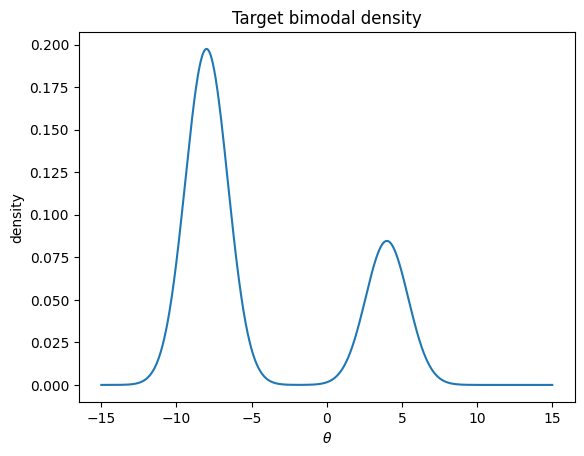

In [38]:
from Metropolis_Hastings import MetropolisHastings

def gen_proposal(sigma):
    return lambda mean: np.random.normal(loc=mean, scale=sigma)

def log_proposal(sigma):
    return lambda x, mean: norm.logpdf(x, loc=mean, scale=sigma)

def multimodal_log_posterior(weights, means, sigma):
    weights = weights / np.sum(weights)
    return lambda x: logsumexp(np.log(weights)-0.5*((x-means)/sigma)**2)

def target_multimodal_posterior(x, weights, means, sigma):
    sum = 0
    weights = weights / np.sum(weights)
    for i in range(len(weights)):
        sum += weights[i]*norm.pdf(x, means[i], sigma)
    return sum

w = np.array([0.7, 0.3])
m = np.array([-8, 4])
s = np.sqrt(2)

x = np.linspace(-15, 15, 1000)
plt.plot(x, target_multimodal_posterior(x, w, m, s))
plt.xlabel(r"$\theta$")
plt.ylabel("density")
plt.title("Target bimodal density")
plt.show()

If we apply our Metropolis-Hastings sampler initialised at $-10$ with proposal standard deviation $\sigma=0.5$, we can see that on first look, our trace plot might look fine - it seems to have reached an area of high probability density and is mixing well. But by comparing our histogram approximation using our MCMC output (with discarding $2000$ samples for burn-in), we can see that it has not been able to move across to the other mode.

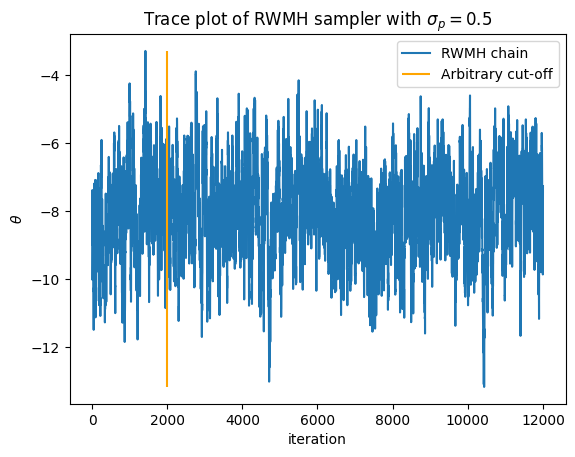

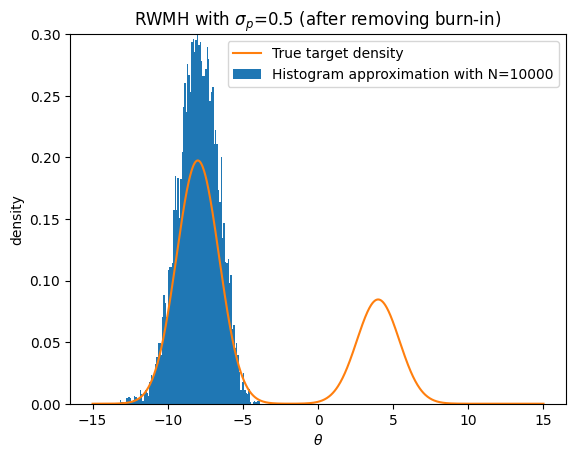

In [39]:
# initialise the sampler at -10 and let variance = 0.1
start_point = -10
proposal_sigma = 0.5
sampler = MetropolisHastings(start_point,
                             gen_proposal(proposal_sigma),
                             log_proposal(proposal_sigma),
                             multimodal_log_posterior(w, m, s))
burn_in = 2000
num_samples = 10000
sampler.MH_sample(num_samples+burn_in)

plt.plot(range(1, len(sampler.chain)+1), sampler.chain)
plt.vlines(x=burn_in, ymin=min(sampler.chain), ymax=max(sampler.chain), colors='orange')
plt.xlabel("iteration")
plt.ylabel(r"$\theta$")
plt.title(r"Trace plot of RWMH sampler with $\sigma_{p}=$"+str(proposal_sigma))
plt.legend(['RWMH chain', 'Arbitrary cut-off'])
plt.show()

plt.hist(sampler.chain[burn_in+1:], bins = 100, density=True)
x = np.linspace(-15, 15, 1000)
plt.plot(x, target_multimodal_posterior(x, w, m, s))
plt.xlabel(r"$\theta$")
plt.ylabel("density")
plt.ylim([0, 0.3])
plt.legend(['True target density', 'Histogram approximation with N={}'.format(num_samples)])
plt.title(r"RWMH with $\sigma_{p}$="+"{} (after removing burn-in)".format(proposal_sigma))
plt.show()

It is well known that MCMC struggles with multimodality because the most popular, and typically most effective, MCMC algorithm have what is called *local proposal mechanisms* meaning that the proposal moves are typically local (an independent sampler would be an example of a global proposal mechanism). They're called local as their proposal typically depends on the current location of the chain. While this is typically a good property of MCMC samplers, it means that for multimodal problems, it is not able to move between modes if there is little *bridging-mass* (i.e. there is little probably density between modes).

In our toy example, we should be able to still implement a Metropolis-Hastings algorithm that is able to move between modes, but for more difficult problems, we would need to look at more advanced MCMC approaches such as *parallel tempering*, which we won't look at here.

And so, if we continue sampling, we should eventually explore the other mode...

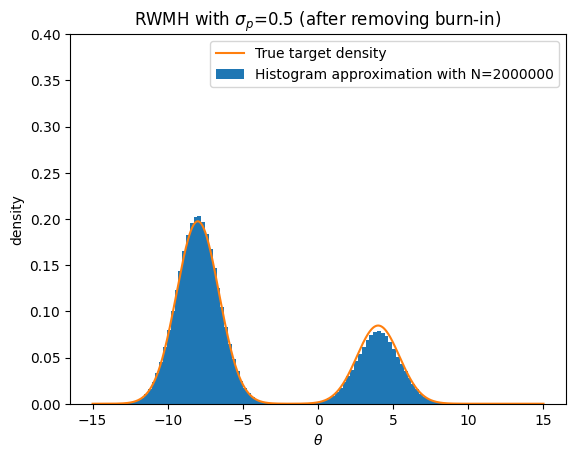

In [40]:
## BUT IF WE RUN IT LONG ENOUGH, IT SHOULD EVENTUALLY EXPLORE THE OTHER MODE
extend_num_samples = 2000000
sampler.MH_sample(extend_num_samples-num_samples)
plt.hist(sampler.chain[burn_in+1:], bins = 100, density=True)
x = np.linspace(-15, 15, 1000)
plt.plot(x, target_multimodal_posterior(x, w, m, s))
plt.xlabel(r"$\theta$")
plt.ylabel("density")
plt.ylim([0, 0.4])
plt.legend(['True target density', 'Histogram approximation with N={}'.format(extend_num_samples)])
plt.title(r"RWMH with $\sigma_{p}$="+"{} (after removing burn-in)".format(proposal_sigma))
plt.show()

Even in this contrived example, we have to have quite a lot of samples before our chain is able to explore both modes. So in practice, even if we construct a Markov chain which should be able to visit every part of the space with a non-negative probability, we might not be able to actually explore all areas of significant probability mass with finite computation.

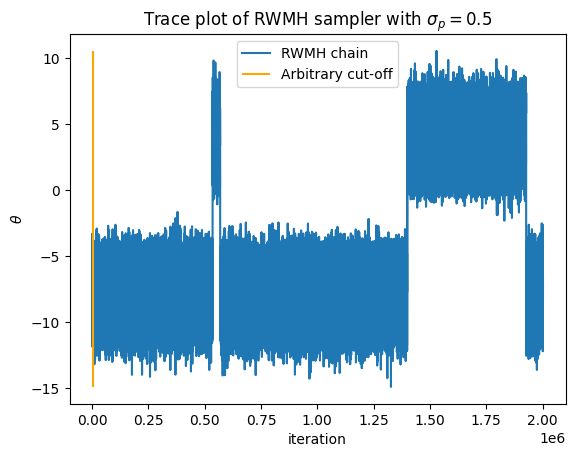

In [41]:
plt.plot(range(1, len(sampler.chain)+1), sampler.chain)
plt.vlines(x=burn_in, ymin=min(sampler.chain), ymax=max(sampler.chain), colors='orange')
plt.xlabel("iteration")
plt.ylabel(r"$\theta$")
plt.title(r"Trace plot of RWMH sampler with $\sigma_{p}=$"+str(proposal_sigma))
plt.legend(['RWMH chain', 'Arbitrary cut-off'])
plt.show()

## Looking at the effect of different proposals

By looking at choosing different standard deviations for our proposal, we can see the importance of choosing an appropriate proposal mechanism to construct our MCMC sampler. We look at both trace plots and autocorrelation plots:

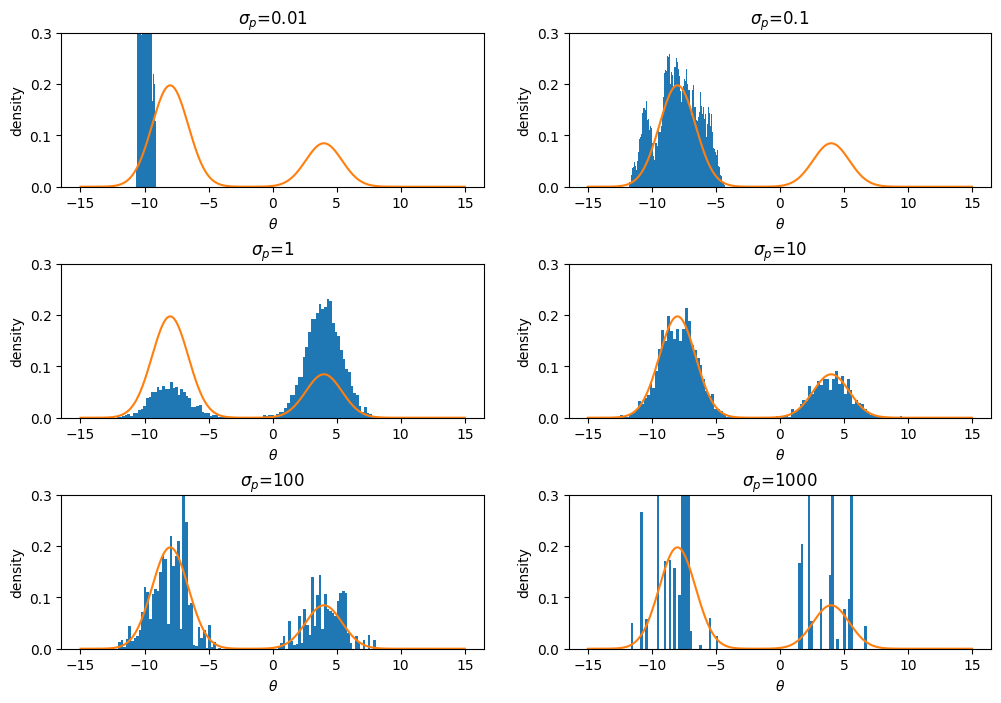

In [42]:
test_sigmas = [0.01, 0.1, 1, 10, 100, 1000]
plt.subplots(3, 2, figsize=(12,8))
plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
x = np.linspace(-15, 15, 1000)
for i in range(0, len(test_sigmas)):
    MH_sampler = MetropolisHastings(start_point,
                                    gen_proposal(test_sigmas[i]),
                                    log_proposal(test_sigmas[i]),
                                    multimodal_log_posterior(w, m, s))
    MH_sampler.MH_sample(num_samples+burn_in)
    ax = plt.subplot(3, 2, i+1)
    ax.hist(MH_sampler.chain[burn_in+1:], bins = 100, density=True)
    ax.plot(x, target_multimodal_posterior(x, w, m, s))
    ax.set_xlabel(r"$\theta$")
    ax.set_ylabel("density")
    ax.set_ylim([0, 0.3])
    ax.set_title(r"$\sigma_{p}$="+str(test_sigmas[i]))

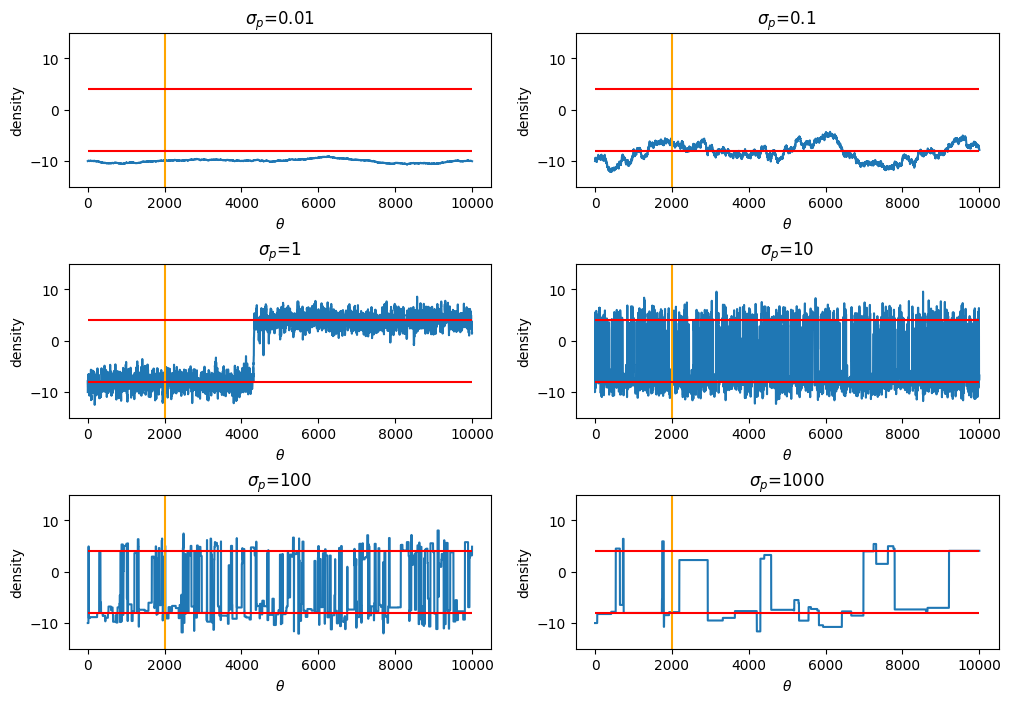

In [43]:
plt.subplots(3, 2, figsize=(12,8))
plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
for i in range(0, len(test_sigmas)):
    MH_sampler = MetropolisHastings(start_point,
                                    gen_proposal(test_sigmas[i]),
                                    log_proposal(test_sigmas[i]),
                                    multimodal_log_posterior(w, m, s))
    MH_sampler.MH_sample(10000)
    ax = plt.subplot(3, 2, i+1)
    ax.set_ylim([-15,15])
    ax.set_xlabel(r"$\theta$")
    ax.set_ylabel("density")
    ax.set_title(r"$\sigma_{p}$="+str(test_sigmas[i]))
    ax.plot(range(1, len(MH_sampler.chain)+1), MH_sampler.chain)
    ax.vlines(x=burn_in, ymin=-20, ymax=15, colors='orange')
    ax.hlines(y=m, xmin=0, xmax=10000, colors = 'red')

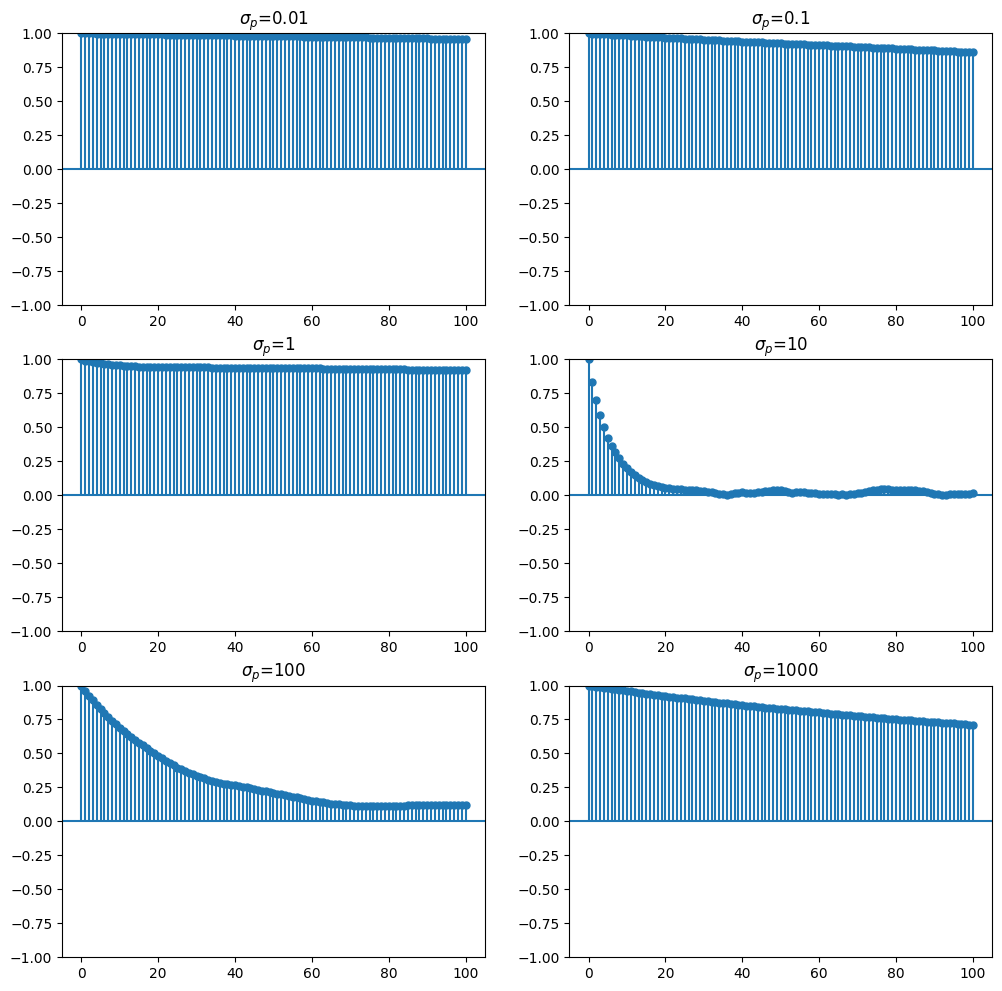

In [44]:
plt.subplots(3, 2, figsize=(12,12))
for i in range(0, len(test_sigmas)):
    MH_sampler = MetropolisHastings(start_point,
                                    gen_proposal(test_sigmas[i]),
                                    log_proposal(test_sigmas[i]),
                                    multimodal_log_posterior(w, m, s))
    MH_sampler.MH_sample(10000)
    ax = plt.subplot(3, 2, i+1)
    plot_acf(MH_sampler.chain, ax = ax, lags = 100, bartlett_confint = False, alpha = None,
             title = r"$\sigma_{p}$="+str(test_sigmas[i]))

From both the trace plots and autocorrelation plots, it's clear that the best choice for the proposal was to set $\sigma_{p}=10$ out of the choices that we looked at. With this choice, we can see that our sampler was able to mix well across the two modes and had the lowest autocorrelation.